In [1]:
import pandas as pd
import numpy as np
import scipy.io
import math
from collections import Counter
import copy
import warnings
import tensorflow as tf
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import BatchNormalization
warnings.filterwarnings("ignore")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):

            pretty(value, indent + 2)
            print('-----------------------')
        else:
            print('\t' * (indent + 2) + str(value))
            print(" ")
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]
def extractSubject(name):
    ex1Path = 'DB1/' + name + '/' + name + '_A1_E1.mat'
    print(ex1Path)
    ex1 = scipy.io.loadmat(ex1Path)
    emg = ex1['emg']
    EMGdf = pd.DataFrame.from_dict(emg)
    stimulus = ex1['stimulus']

    ex2Path = 'DB1/' + name + '/' + name + '_A1_E2.mat'
    ex2 = scipy.io.loadmat(ex2Path)
    emg2 = ex2['emg']
    EMGdf2 = pd.DataFrame.from_dict(emg2)
    stimulus2 = ex2['stimulus']

    ex3Path = 'DB1/' + name + '/' + name + '_A1_E3.mat'
    ex3 = scipy.io.loadmat(ex3Path)
    emg3 = ex3['emg']
    EMGdf3 = pd.DataFrame.from_dict(emg3)
    stimulus3 = ex3['stimulus']

    Movements = {}
    for m in range(1, 53):
        if (m < 13):
            movementIndices = np.where(stimulus == m)[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf
        elif (m < 30):
            movementIndices = np.where(stimulus2 == (m - 12))[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf2
        else:
            movementIndices = np.where(stimulus3 == (m - 29))[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf3

        Repetitions = {}
        for r in range(1, 7):
            startIndex = repetitions[r - 1][0]
            LastIndex = repetitions[r - 1][len(repetitions[r - 1]) - 1]
            df = EMG.iloc[startIndex:LastIndex, 0:10]
            df.reset_index(drop=True, inplace=True)
            Repetitions["R{0}".format(r)] = df
        Movements["Movement{0}".format(m)] = Repetitions
    return Movements
def Average(lst):
    return sum(lst) / len(lst)


In [109]:

columns = {'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'Train','Movement'}
X_train_2 = []
y_train_2 = []
X_test_2 = []
y_test_2 = []
for s in range(1,28):
    subject = 'S' + str(s)
    dff = pd.DataFrame.from_dict(extractSubject(subject))
    for m in range(13,30):
        M = dff['Movement'+str(m)]
        for r in range(1,7): 
            r_index = "R" + str(r)
            rep = M[r_index]
            if (r in [1, 3, 4, 6]):
                train = True
            else:
                train = False
            i=0    
            for x in range(0, len(rep), 1):
                entry = rep.iloc[x:x+20, :]
                entry.columns = {'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10'}
                entry.reset_index(drop=True, inplace=True)
                matrix = entry.to_numpy()
                if matrix.shape[0]==20:
                    # matrix = matrix.transpose()
                    if(train):
                        X_train_2.append(matrix)
                        y_train_2.append(m)
                    else :
                        X_test_2.append(matrix)
                        y_test_2.append(m)    
                    i+=1
                       


DB1/S1/S1_A1_E1.mat
DB1/S2/S2_A1_E1.mat
DB1/S3/S3_A1_E1.mat
DB1/S4/S4_A1_E1.mat
DB1/S5/S5_A1_E1.mat
DB1/S6/S6_A1_E1.mat
DB1/S7/S7_A1_E1.mat
DB1/S8/S8_A1_E1.mat
DB1/S9/S9_A1_E1.mat
DB1/S10/S10_A1_E1.mat
DB1/S11/S11_A1_E1.mat
DB1/S12/S12_A1_E1.mat
DB1/S13/S13_A1_E1.mat
DB1/S14/S14_A1_E1.mat
DB1/S15/S15_A1_E1.mat
DB1/S16/S16_A1_E1.mat
DB1/S17/S17_A1_E1.mat
DB1/S18/S18_A1_E1.mat
DB1/S19/S19_A1_E1.mat
DB1/S20/S20_A1_E1.mat
DB1/S21/S21_A1_E1.mat
DB1/S22/S22_A1_E1.mat
DB1/S23/S23_A1_E1.mat
DB1/S24/S24_A1_E1.mat
DB1/S25/S25_A1_E1.mat
DB1/S26/S26_A1_E1.mat
DB1/S27/S27_A1_E1.mat


In [110]:
X_train = np.array(X_train_2)
X_test = np.array(X_test_2)
y_train = np.array(y_train_2)
print("X Train shape: ", X_train.shape)
print("X Test shape: ", X_test.shape)
print("Y Train shape: ", y_train.shape)
print('------------------')
X_train = np.array(X_train).reshape(X_train.shape[0],20,10)
X_test = np.array(X_test).reshape(X_test.shape[0],20,10)
y_train = np.array(y_train).astype('float32').reshape(X_train.shape[0],1)
y_test = np.array(y_test_2).astype('float32').reshape(X_test.shape[0],1)

y_train= tf.one_hot(y_train,52)
y_test= tf.one_hot(y_test,52)
y_test = np.array(y_test).astype('float32').reshape(X_test.shape[0],52)
y_train = np.array(y_train).astype('float32').reshape(X_train.shape[0],52)

print("X Train shape: ", X_train.shape)
print("X Test shape: ", X_test.shape)
print("Y Train shape: ", y_train.shape)

X Train shape:  (912985, 20, 10)
X Test shape:  (456351, 20, 10)
Y Train shape:  (912985,)
------------------
X Train shape:  (912985, 20, 10)
X Test shape:  (456351, 20, 10)
Y Train shape:  (912985, 52)


In [116]:
input = Input(shape =(20,10,1))
x = Conv2D(32,(1,10), kernel_initializer='glorot_normal', activation='relu', padding='same', input_shape = (20,10))(input)
x = Dropout(0.15)(x)

x = Conv2D(32,(3,3),kernel_initializer='glorot_normal', activation='relu' ,padding='same')(x)
x = Dropout(0.15)(x)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64,(5,5), kernel_initializer='glorot_normal', activation='relu', padding='same')(x)
x = Dropout(0.15)(x)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64,(5,1), kernel_initializer='glorot_normal', activation='relu', padding='same')(x)
x = Dropout(0.15)(x)
x = Flatten()(x)
ouput = Dense(52, kernel_initializer='glorot_normal', activation='softmax')(x)


model = Model(input, ouput)
model.compile(optimizer=SGD(learning_rate=0.02), loss="categorical_crossentropy", metrics=['accuracy'])
print(X_train.shape)

history = model.fit(X_train, y_train, epochs=35, validation_data= (X_test, y_test))
print(model.evaluate(X_test, y_test))

(912985, 20, 10)
Epoch 1/35
28531/28531 [==============================] - 223s 8ms/step - loss: 2.3121 - accuracy: 0.2483 - val_loss: 2.0425 - val_accuracy: 0.3522
Epoch 2/35
28531/28531 [==============================] - 275s 10ms/step - loss: 1.8778 - accuracy: 0.3875 - val_loss: 1.8554 - val_accuracy: 0.4063
Epoch 3/35
28531/28531 [==============================] - 220s 8ms/step - loss: 1.7190 - accuracy: 0.4385 - val_loss: 1.7833 - val_accuracy: 0.4303
Epoch 4/35
28531/28531 [==============================] - 628s 22ms/step - loss: 1.6366 - accuracy: 0.4650 - val_loss: 1.7586 - val_accuracy: 0.4379
Epoch 5/35
28531/28531 [==============================] - 16145s 566ms/step - loss: 1.5810 - accuracy: 0.4823 - val_loss: 1.7078 - val_accuracy: 0.4603
Epoch 6/35
28531/28531 [==============================] - 216s 8ms/step - loss: 1.5430 - accuracy: 0.4936 - val_loss: 1.6962 - val_accuracy: 0.4603
Epoch 7/35
28531/28531 [==============================] - 223s 8ms/step - loss: 1.5149 - 

In [125]:
input = Input(shape =(20,10,1))

x = BatchNormalization()(input)
x = ZeroPadding2D((0,4))(x)
x = Conv2D(32,(1,10), kernel_initializer='glorot_normal', activation='relu', padding='valid', input_shape = (20,10))(x)
x = Dropout(0.15)(x)

x = ZeroPadding2D((1,1))(x)
x = Conv2D(32,(3,3),kernel_initializer='glorot_normal', activation='relu' ,padding='valid')(x)
x = Dropout(0.15)(x)
x = MaxPooling2D((3,3), strides = (3,3))(x)

x = ZeroPadding2D((2,2))(x)
x = Conv2D(64,(5,5), kernel_initializer='glorot_normal', activation='relu', padding='valid')(x)
x = Dropout(0.15)(x)
x = MaxPooling2D((4,3), strides = (4,3))(x)

x = ZeroPadding2D((2,0))(x)
x = Conv2D(64,(5,1), kernel_initializer='glorot_normal', activation='relu', padding='valid')(x)
x = Dropout(0.15)(x)

x = Conv2D(52, (1, 1), padding='same', activation='softmax',kernel_initializer='glorot_normal')(x)
x = Reshape((-1,))(x)

model = Model(inputs = input, outputs = x)
model.summary()
model.compile(optimizer=SGD(learning_rate=0.05), loss="categorical_crossentropy", metrics=['accuracy'])
print(X_train.shape)

print(y_train.shape)
history = model.fit(X_train, y_train, epochs=35, batch_size=512, validation_data=(X_test, y_test))
print(model.evaluate(X_test, y_test))


Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 20, 10, 1)]       0         
                                                                 
 batch_normalization_33 (Bat  (None, 20, 10, 1)        4         
 chNormalization)                                                
                                                                 
 zero_padding2d_127 (ZeroPad  (None, 20, 18, 1)        0         
 ding2D)                                                         
                                                                 
 conv2d_228 (Conv2D)         (None, 20, 9, 32)         352       
                                                                 
 dropout_203 (Dropout)       (None, 20, 9, 32)         0         
                                                                 
 zero_padding2d_128 (ZeroPad  (None, 22, 11, 32)       0  

In [98]:

input = Input(shape =(20,10,1))

x = BatchNormalization()(input)
x = ZeroPadding2D((0,4))(x)
x = Conv2D(32,(1,10), kernel_initializer='glorot_normal', activation='relu', padding='valid', input_shape = (20, 10))(x)
x = Dropout(0.15)(x)

x = ZeroPadding2D((1,1))(x)
x = Conv2D(32,(3,3),kernel_initializer='glorot_normal', activation='relu' ,padding='valid')(x)
x = Dropout(0.15)(x)
x = MaxPooling2D((5,3), strides = (5,3))(x)

x = ZeroPadding2D((2,2))(x)
x = Conv2D(64,(5,5), kernel_initializer='glorot_normal', activation='relu', padding='valid')(x)
x = Dropout(0.15)(x)
x = MaxPooling2D((5,3), strides = (5,3))(x)

x = ZeroPadding2D((2,0))(x)
x = Conv2D(64,(6,1), kernel_initializer='glorot_normal', activation='relu', padding='valid')(x)
x = Dropout(0.15)(x)

x = Conv2D(52, (1, 1), padding='same', activation='softmax',kernel_initializer='glorot_normal')(x)
x = Reshape((-1,))(x)

model = Model(inputs = input, outputs = x)
model.summary()
model.compile(optimizer=SGD(learning_rate=0.005), loss="categorical_crossentropy", metrics=['accuracy'])
print(X_train.shape)

print(y_train.shape)
history = model.fit(X_train, y_train, epochs=35, validation_data= (X_test, y_test))
print(model.evaluate(X_test, y_test))


ValueError: Exception encountered when calling layer "max_pooling2d_74" (type MaxPooling2D).

Negative dimension size caused by subtracting 5 from 4 for '{{node max_pooling2d_74/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 5, 3, 1], padding="VALID", strides=[1, 5, 3, 1]](Placeholder)' with input shapes: [?,4,3,64].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 4, 3, 64), dtype=float32)

In [117]:

# model.summary()
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
class_labels = np.argmax(y_pred, axis=1) 
y_df = pd.DataFrame(class_labels)
y_df.to_csv('y_pred.csv')
class_labels_2 = np.argmax(y_test, axis=1) 
y_df_2 = pd.DataFrame(class_labels_2)
y_df_2.to_csv('y_test.csv')
print(class_labels)
print(class_labels_2)
y_test_new = [most_frequent(class_labels_2[x:x + 496]) for x in range(0, len(class_labels_2), 496)]
y_predicted_new = [most_frequent(class_labels[x:x + 496]) for x in range(0, len(class_labels), 496)]
accuracy_modified = accuracy_score(y_test_new, y_predicted_new)
print(accuracy_modified)
# print(i)




[27 27 27 ... 14 14 25]
[13 13 13 ... 29 29 29]
0.9001085776330076


In [126]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
class_labels = np.argmax(y_pred, axis=1) 
y_df = pd.DataFrame(class_labels)
y_df.to_csv('y_pred.csv')
class_labels_2 = np.argmax(y_test, axis=1) 
y_df_2 = pd.DataFrame(class_labels_2)
y_df_2.to_csv('y_test.csv')
print(class_labels)
print(class_labels_2)
y_test_new = [most_frequent(class_labels_2[x:x + 496]) for x in range(0, len(class_labels_2), 496)]
y_predicted_new = [most_frequent(class_labels[x:x + 496]) for x in range(0, len(class_labels), 496)]
accuracy_modified = accuracy_score(y_test_new, y_predicted_new)
print(accuracy_modified)

[14 14 14 ... 13 13 18]
[13 13 13 ... 29 29 29]
0.8371335504885994


In [118]:
count = [0] *52
mistake = [0] *52

for i in range(len(y_test_new)):
    count[y_test_new[i]-1] +=1
    if y_test_new[i] != y_predicted_new[i]:
        mistake[y_test_new[i]-1]+=1
mistake = np.array(mistake)
m_sum = np.sum(mistake)
print(m_sum)
print(len(y_test_new))
print(mistake)
ratio = np.divide(mistake,len(y_test_new))
print(ratio)
print("Movement Accuracy", accuracy_modified)

92
921
[ 0  0  0  0  0  0  0  0  0  0  0  0  9  6  0 11  9  3  3  6  7  4  5  9
  5  5  1  2  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00977199 0.00651466 0.         0.01194354 0.00977199 0.00325733
 0.00325733 0.00651466 0.00760043 0.00434311 0.00542888 0.00977199
 0.00542888 0.00542888 0.00108578 0.00217155 0.00760043 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Movement Accuracy 0.9001085776330076


[ 9  6  0 11  9  3  3  6  7  4  5  9  5  5  1  2  7]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


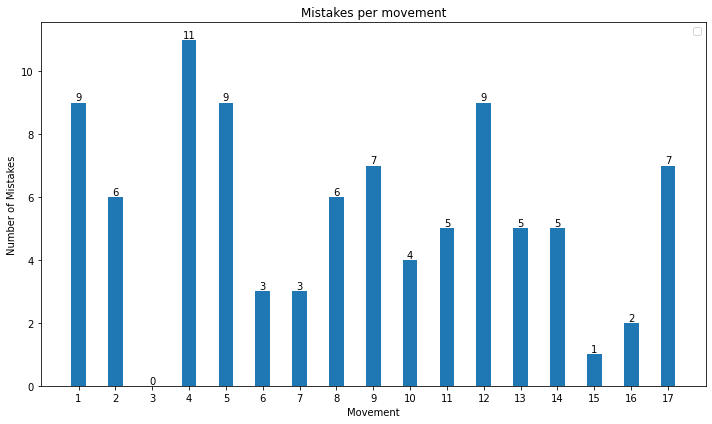

In [119]:
mistake2 = mistake[12:29]
print(mistake2)
fig, ax = plt.subplots(figsize = (10,6))
x = list(range(1, 18))
movement = ax.bar(x, mistake2, 0.4)
ax.set_ylabel('Number of Mistakes')
ax.set_xlabel('Movement')
ax.set_title('Mistakes per movement')
ax.set_xticks(x)
ax.legend()
ax.bar_label(movement)
fig.tight_layout()
plt.show()

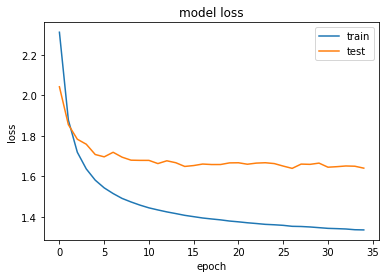

In [121]:
# model.history['accuracy']
# model.history['loss']
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

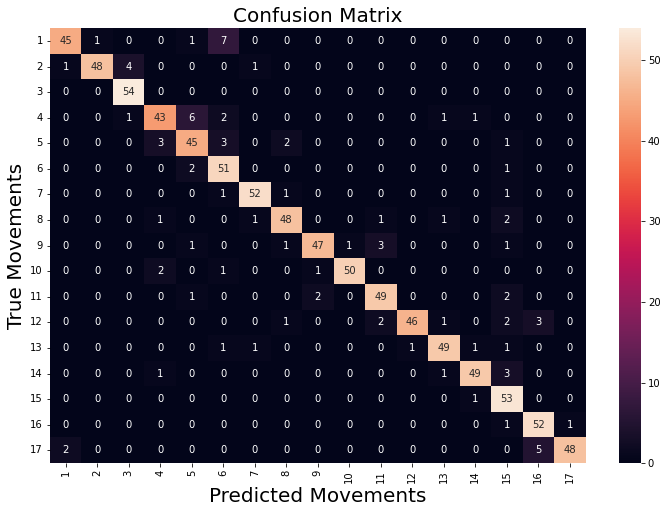

              precision    recall  f1-score   support

          13      0.938     0.833     0.882        54
          14      0.980     0.889     0.932        54
          15      0.915     1.000     0.956        54
          16      0.860     0.796     0.827        54
          17      0.804     0.833     0.818        54
          18      0.773     0.944     0.850        54
          19      0.945     0.945     0.945        55
          20      0.906     0.889     0.897        54
          21      0.940     0.870     0.904        54
          22      0.980     0.926     0.952        54
          23      0.891     0.907     0.899        54
          24      0.979     0.836     0.902        55
          25      0.925     0.907     0.916        54
          26      0.942     0.907     0.925        54
          27      0.779     0.981     0.869        54
          28      0.867     0.963     0.912        54
          29      0.980     0.873     0.923        55

    accuracy              

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

### Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_new, y_predicted_new)

## Get Class Labels
# labels = le.classes_
class_names = range(1,18)

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(12, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted Movements', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Movements', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()
print(metrics.classification_report(y_test_new, y_predicted_new, digits=3))